**Time Series Analysis of the S&P 500 Index from January 4th, 2010 to December 30th, 2019 using Facebook Prophet, LSTM, and ARIMA**

**1. Imports**

We begin by importing the required libraries.

In [2]:
#Importing libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
# prophet model 
from fbprophet import Prophet
# prophet preformance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

**2. Exploratory Data Analysis**

First, we load in our data and take a look at its structure.

In [3]:
#Reading our data into a pandas dataframe
sp = pd.read_csv('SP500.csv')

In [4]:
sp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [5]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 7 columns):
Date         2515 non-null object
Open         2515 non-null float64
High         2515 non-null float64
Low          2515 non-null float64
Close        2515 non-null float64
Adj Close    2515 non-null float64
Volume       2515 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.6+ KB


In [6]:
#Checking for missing data
sp.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

**3. Forecasting using Facebook Prophet**

In this section, we perform time series forecasting using Facebook's prophet library. 

We only require the date and adjusted close features for this task. So we truncate our dataset accordingly:

In [7]:
sp=sp[['Date','Adj Close']]

In [8]:
sp.head()

,Date,Adj Close
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015
3,2010-01-07,1141.689941
4,2010-01-08,1144.979980


In [9]:
sp.Date = pd.to_datetime(sp.Date)

Now we change the column names to comply with Prophet.

In [10]:
sp.columns=['ds','y']

In [11]:
train, dev, test = sp[:1800], sp[1800:2250], sp[2250:]

In [12]:
train.head()

,ds,y
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015
3,2010-01-07,1141.689941
4,2010-01-08,1144.979980


In [13]:
dev.head()

,ds,y
1800,2017-02-28,2363.639893
1801,2017-03-01,2395.959961
1802,2017-03-02,2381.919922
1803,2017-03-03,2383.120117
1804,2017-03-06,2375.310059


In [14]:
test.head()

,ds,y
2250,2018-12-11,2636.780029
2251,2018-12-12,2651.070068
2252,2018-12-13,2650.540039
2253,2018-12-14,2599.949951
2254,2018-12-17,2545.939941


In [15]:
type(train.ds[0])

pandas._libs.tslibs.timestamps.Timestamp

Let's plot out our data.

Text(0.5, 1.0, 'S&P 500 Index')

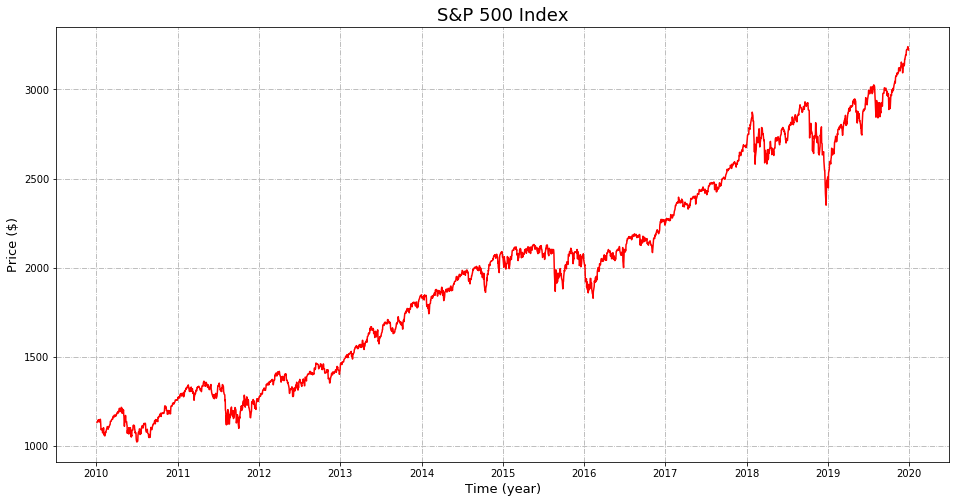

In [75]:
# Setting our layout
plt.figure(figsize=(16,8))
plt.grid(linestyle='-.')

#Plot the data
plt.plot(sp.ds, sp.y, 'r')

# Set title & labels
plt.ylabel('Price ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)
plt.title('S&P 500 Index', fontsize=18)

**3.2 Creating our Model**

In [17]:
prophet = Prophet(yearly_seasonality=False, weekly_seasonality=True)

In [18]:
#prophet.add_country_holidays(country_name='US')

In [19]:
len(dev)

450

In [20]:
prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
make_forecast=prophet.make_future_dataframe(periods=len(dev),freq='D')

In [22]:
forecast = prophet.predict(make_forecast)

Text(0.5, 1, 'S&P 500 Index')

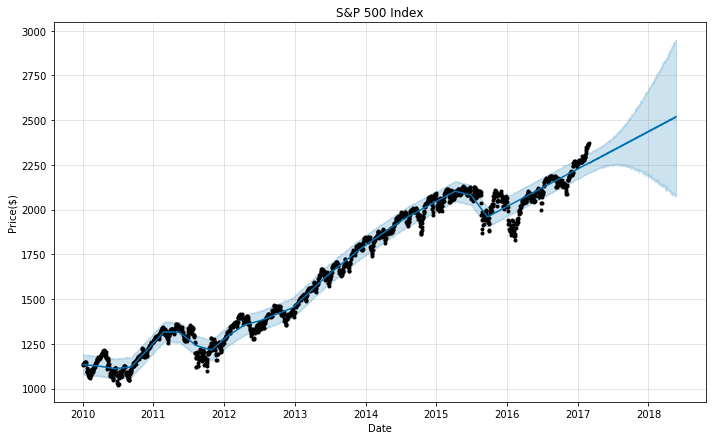

In [23]:
# plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel='Price($)')
plt.title('S&P 500 Index')

In the plot above:

I) Black points represent actual observations from our training set.

II) The blue line represents Prophet's predictions.

III) The blue funnel shape represents the uncertainty intervals.

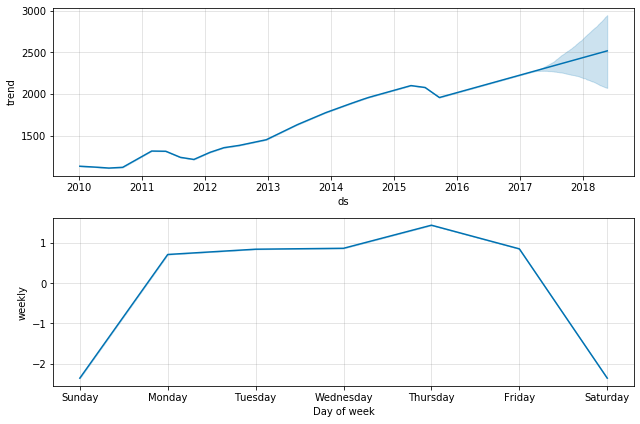

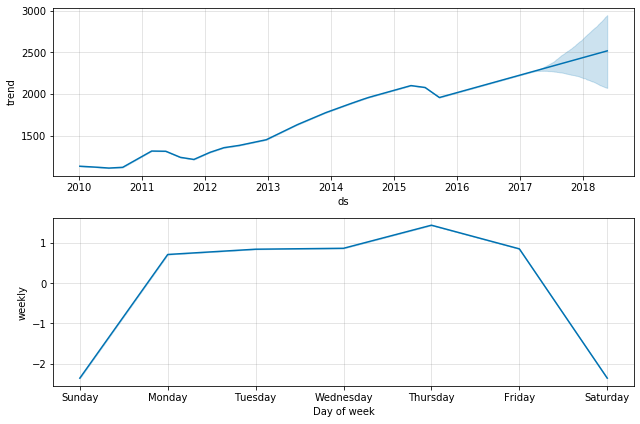

In [24]:
prophet.plot_components(forecast)

In [25]:
future_preds = forecast.loc[1800:]
future_preds = future_preds[['ds','yhat','yhat_lower','yhat_upper']]
future_preds.head(5)

,ds,yhat,yhat_lower,yhat_upper
1800,2017-02-28,2261.171144,2206.158352,2316.748167
1801,2017-03-01,2261.769138,2209.106805,2313.810131
1802,2017-03-02,2262.917254,2206.710240,2319.861941
1803,2017-03-03,2262.905618,2210.013908,2317.974140
1804,2017-03-04,2260.271823,2204.815102,2314.391378


In [26]:
future_preds.head()

,ds,yhat,yhat_lower,yhat_upper
1800,2017-02-28,2261.171144,2206.158352,2316.748167
1801,2017-03-01,2261.769138,2209.106805,2313.810131
1802,2017-03-02,2262.917254,2206.710240,2319.861941
1803,2017-03-03,2262.905618,2210.013908,2317.974140
1804,2017-03-04,2260.271823,2204.815102,2314.391378


In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [63]:
mean_absolute_error(dev['y'],future_preds['yhat'])

235.6288874221651

In [64]:
mean_squared_error(dev['y'],future_preds['yhat'])

66779.08516442966

**4. Forecasting using ARIMA**

In this section we utilize the Autoregressive Integrated Moving Average (ARIMA) technique to model our data. This technique incorporates both autoregressive and moving average components into the modeling of a stationary stochastic process.

Finance theory tells us that the expected value of a stock price increases exponentially (by the interest rate) with time. And the expected value of the log of the stock price necessarily increases linearly with time. Hence, we will use the log of the S&P 500 Index for our ARIMA (p,1,q) modeling, since ARIMA (p,1,q) aims to produce a stationary stochastic process after first-order differencing.

In [254]:
#Creating a daaframe of log-prices
sp_log = np.log(sp['y'])
log_df = pd.concat([sp['ds'],sp_log],axis=1)
log_df = log_df.set_index('ds')
log_df.head()

,y
ds,
2010-01-04,7.032615
2010-01-05,7.035726
2010-01-06,7.036272
2010-01-07,7.040265
2010-01-08,7.043142


Let's take a look at the log-S&P 500 process.

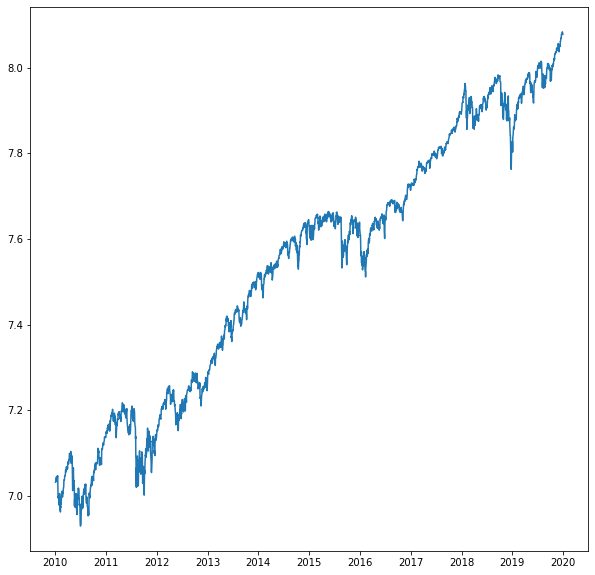

In [257]:
#Plotting the log values
plt.figure(figsize=(10,10))
plt.plot(log_df.index,sp_log)

In [240]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**4.1 Testing for Stationarity**

In the following block of code, we apply the differencing formula: $\tilde{y_t} = y_t - y_{t-1}$ to the log of the S&P 500 Index to derive a new stochastic process. We then test if it's stationary using
rolling statistics and the augmented Dickey-Fuller (ADF) test.

ADF Statistic: -11.376204457390664
p-value: 8.733279855847892e-21
Critical Values:
	1%: -3.4329799947351503
	5%: -2.862701915447137
	10%: -2.5673885329713495


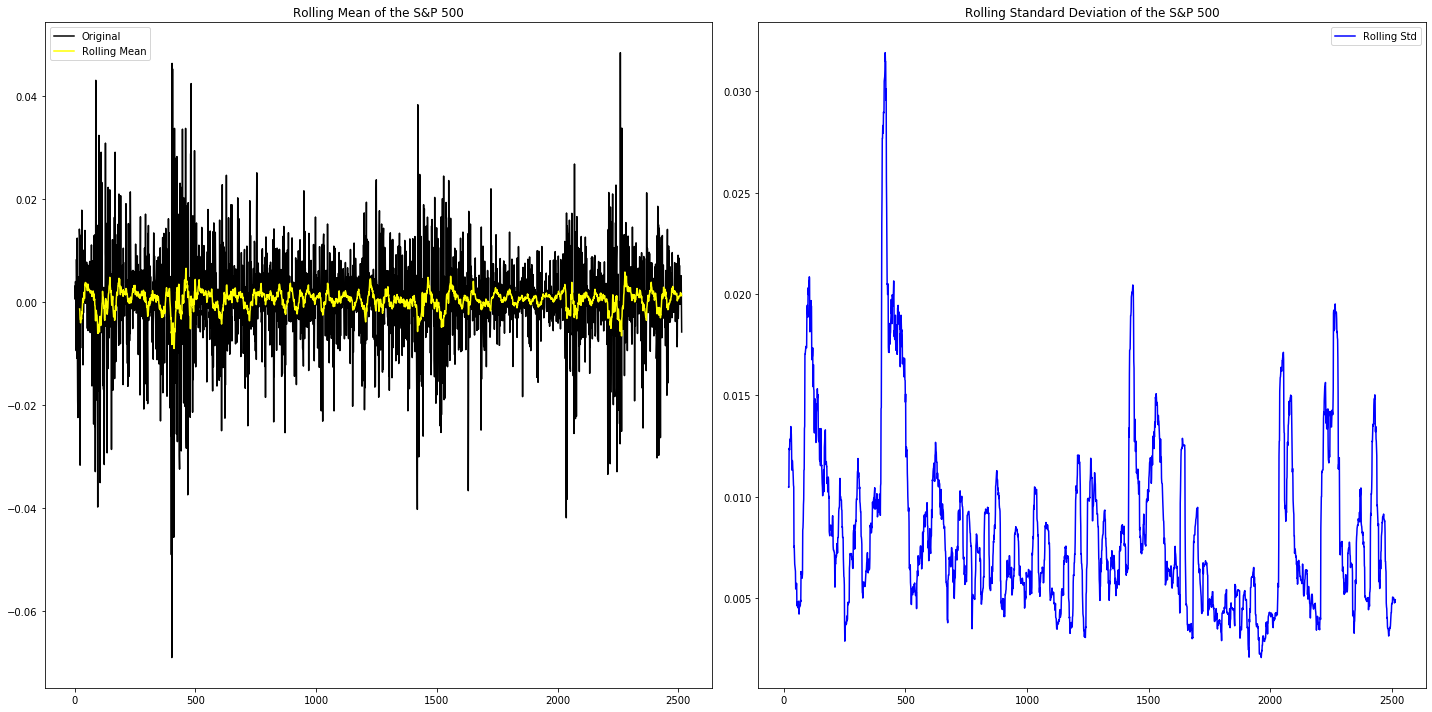

In [242]:
def stationarityTest(timeseries):
    
    #Determining the rolling statistics, using a window of 20 days
    rolling_mean = timeseries.rolling(window=20).mean()
    rolling_std = timeseries.rolling(window=20).std()
    
    #Plotting the rolling statistics
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    axes[0].plot(timeseries, color='black', label='Original')
    axes[0].plot(rolling_mean, color='yellow', label='Rolling Mean')
    axes[0].legend(loc='best')
    axes[0].set_title('Rolling Mean of the S&P 500')
    axes[1].plot(rolling_std, color='blue', label='Rolling Std')
    axes[1].legend(loc='best')
    axes[1].set_title('Rolling Standard Deviation of the S&P 500')
    fig.tight_layout()

    
    #Augmented Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

#Computing the differenced log-price process
log_diff = sp_log - sp_log.shift(1)
log_diff.dropna(inplace=True)

#Testing for stationarity
stationarityTest(log_diff)

We obtain an extremely low p-value which indicates that the differenced process, plotted above, is stationary.

**4.2 Autocorrelation and Partial Autocorrelation**

In this section, we investigate the autocorrelation and partial autocorrelation between steps in time, in order to select the p and q parameters of our ARIMA model. 

For AR models, the partial autocorrelation function (PACF) plot
is used to determine the order, denoted as p, of the model. While for MA models, the autocorrelation function (ACF) is used to select its order, q.

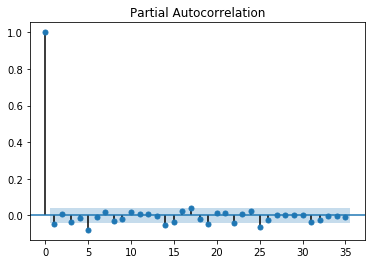

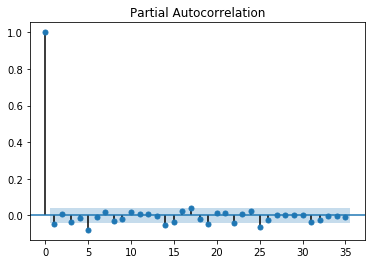

In [233]:
from statsmodels.graphics import tsaplots
tsaplots.plot_pacf(log_diff)

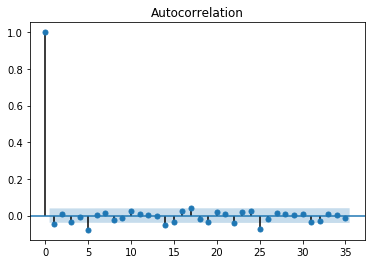

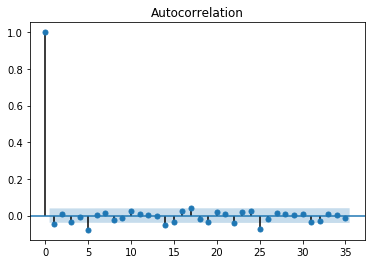

In [234]:
tsaplots.plot_acf(log_diff)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2514
Model:                 ARIMA(5, 1, 1)   Log Likelihood                8200.423
Method:                       css-mle   S.D. of innovations              0.009
Date:                Sun, 24 May 2020   AIC                         -16384.845
Time:                        00:18:59   BIC                         -16338.208
Sample:                             1   HQIC                        -16367.919
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.653      0.008       0.000       0.001
ar.L1.D.y      0.0110      0.223      0.049      0.961      -0.427       0.449
ar.L2.D.y      0.0050      0.022      0.221      0.8

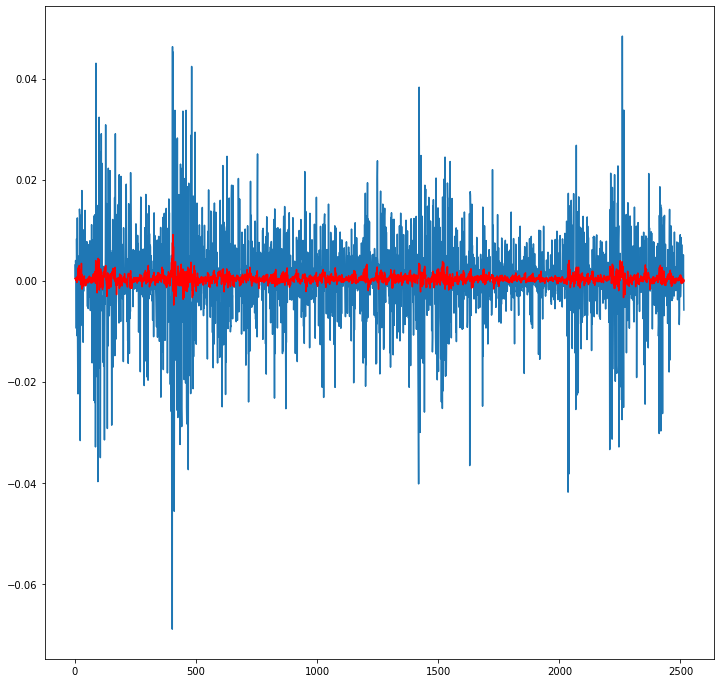

In [250]:
model = ARIMA(np.asarray(log_df), order=(5,1,1))
results = model.fit(disp=-1) 
print(results.summary())
plt.figure(figsize=(12,12))
plt.plot(sp.index[1:],log_diff)
plt.plot(sp.index[1:],results.fittedvalues, color='red')

predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = np.array(predictions_ARIMA_diff.cumsum())
#print(predictions_ARIMA_diff_cumsum)
predictions_ARIMA_diff_cumsum = pd.Series(np.insert(predictions_ARIMA_diff_cumsum,0,0))
predictions_ARIMA = pd.Series(log_df['y'].iloc[0],index=sp.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum)
predictions_ARIMA = np.exp(predictions_ARIMA)


2515
113.55672474194436


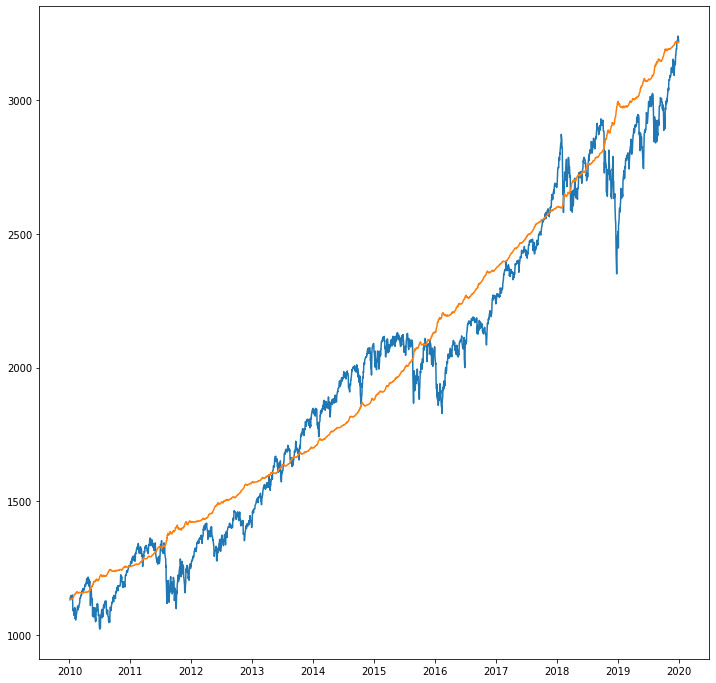

In [252]:
plt.figure(figsize=(12,12))
plt.plot(log_df.index,sp['y'])
print(len(log_df.index))
plt.plot(log_df.index,predictions_ARIMA)

print(mean_absolute_error(sp['y'].iloc[1800:],predictions_ARIMA[1800:]))

**Forecasting using Keras LSTM Neural Network**

In [258]:
import numpy as np
data = np.zeros((2515,1))
for i in range(len(sp['y'])):
    data[i][0]=sp['y'][i]
data

array([[1132.98999 ],
       [1136.52002 ],
       [1137.140015],
       ...,
       [3239.909912],
       [3240.02002 ],
       [3221.290039]])

In [271]:
from sklearn.preprocessing import MinMaxScaler

In [272]:
scaler = MinMaxScaler(feature_range = (0,1))
data = scaler.fit_transform(data)

In [274]:
#data

In [275]:
train = data[:1900,:]
test = data[1900:,:]

In [276]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [277]:
# create dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX),np.array(dataY)


In [278]:
XTrain, yTrain = create_dataset(train)
XTest, yTest = create_dataset(test)

In [279]:
XTrain = np.reshape(XTrain,(XTrain.shape[0],1,XTrain.shape[1]))
XTest = np.reshape(XTest,(XTest.shape[0],1,XTest.shape[1]))

In [281]:
# let's create  a RNN or LSTM model
model = Sequential()
model.add(LSTM(4,input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# fit the model
model.fit(XTrain,yTrain,batch_size=1,verbose=2,epochs=10)

Epoch 1/10
 - 1s - loss: 0.0117
Epoch 2/10
 - 1s - loss: 5.6624e-05
Epoch 3/10
 - 1s - loss: 5.4621e-05
Epoch 4/10
 - 1s - loss: 5.7768e-05
Epoch 5/10
 - 1s - loss: 5.6589e-05
Epoch 6/10
 - 1s - loss: 5.7388e-05
Epoch 7/10
 - 1s - loss: 5.7630e-05
Epoch 8/10
 - 1s - loss: 5.9125e-05
Epoch 9/10
 - 1s - loss: 5.6584e-05
Epoch 10/10
 - 1s - loss: 5.7129e-05


In [282]:
Predict_train = model.predict(XTrain)
Predict_test = model.predict(XTest)

In [283]:
Predict_train = scaler.inverse_transform(Predict_train)
Predict_test = scaler.inverse_transform(Predict_test)

yTrain = scaler.inverse_transform([yTrain])
yTest = scaler.inverse_transform([yTest])

In [284]:
yTrain

array([[1136.52002 , 1137.140015, 1141.689941, ..., 2459.139893,
        2460.610107, 2473.830078]])

In [285]:
yTrain[0]

array([1136.52002 , 1137.140015, 1141.689941, ..., 2459.139893,
       2460.610107, 2473.830078])

In [289]:
Predict_train

array([[1141.9037],
       [1145.1936],
       [1145.7717],
       ...,
       [2448.3757],
       [2448.258 ],
       [2449.5847]], dtype=float32)

In [293]:
def unroll(dataset):
    res=[]
    for i in range(len(dataset)):
        res.append(dataset[i][0])
    return np.array(res)
Predict_train = unroll(Predict_train)
Predict_test = unroll(Predict_test)

In [295]:
mean_absolute_error(yTrain[0],Predict_train)

11.554565472392815

In [296]:
mean_absolute_error(yTest[0],Predict_test)

64.87759633640907

In [300]:
a=np.array([5])
b=np.array([44])

In [301]:
np.concatenate((a,b),axis=None)

array([ 5, 44])

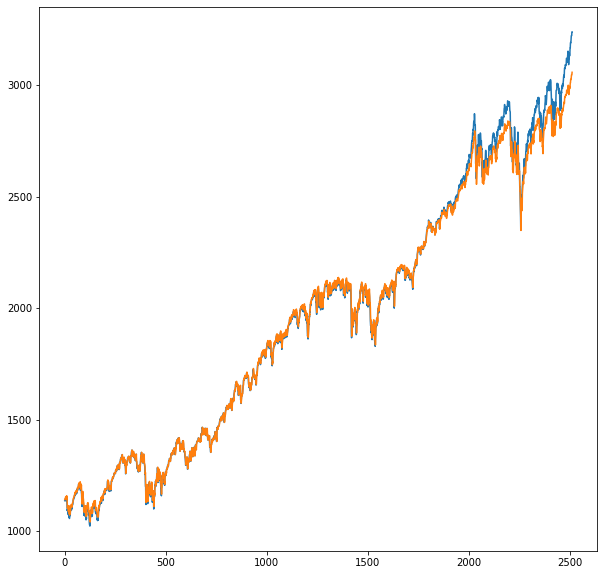

In [306]:
plt.figure(figsize=(10,10))
plt.plot(np.concatenate((yTrain[0],yTest[0]),axis=None))
plt.plot(np.concatenate((Predict_train,Predict_test),axis=None))